In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import math
%matplotlib inline

import sys
sys.path.append('../')
from core.networks import BayesianNetwork as BN
from bayes_layer import BayesianConv2D
from bayes_layer import BayesianLinear
from bayes_layer import _calculate_fan_in_and_fan_out

In [2]:
def compute_conv_output_size(Lin,kernel_size,stride=1,padding=0,dilation=1):
    return int(np.floor((Lin+2*padding-dilation*(kernel_size-1)-1)/float(stride)+1))

In [3]:
class BayesianConvNetwork(nn.Module):
    def __init__(self, inputsize, taskcla, init_type = 'random', rho_init = -4.6001):
        super().__init__()
        
        ncha,size,_=inputsize
        self.taskcla = taskcla
        self.conv1 = BayesianConv2D(ncha,32,kernel_size=3, padding=1, rho_init = rho_init)
        s = compute_conv_output_size(size,3, padding=1)
        self.conv2 = BayesianConv2D(32,32,kernel_size=3, padding=1, rho_init = rho_init)
        s = compute_conv_output_size(s,3, padding=1)
        s = s//2
        self.conv3 = BayesianConv2D(32,64,kernel_size=3, padding=1, rho_init = rho_init)
        s = compute_conv_output_size(s,3, padding=1)
        self.conv4 = BayesianConv2D(64,64,kernel_size=3, padding=1, rho_init = rho_init)
        s = compute_conv_output_size(s,3, padding=1)
        s = s//2
        self.conv5 = BayesianConv2D(64,128,kernel_size=3, padding=1, rho_init = rho_init)
        s = compute_conv_output_size(s,3, padding=1)
        self.conv6 = BayesianConv2D(128,128,kernel_size=3, padding=1, rho_init = rho_init)
        s = compute_conv_output_size(s,3, padding=1)
        s = s//2
        
        self.fc1 = BayesianLinear(s*s*128,256, init_type=init_type, rho_init = rho_init)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        self.MaxPool = torch.nn.MaxPool2d(2)
        
        self.last=torch.nn.ModuleList()
        
        for t,n in self.taskcla:
            self.last.append(torch.nn.Linear(256,n))
        self.relu = torch.nn.ReLU()

    def forward(self, x, sample=False):
        h=self.relu(self.conv1(x,sample))
        h=self.relu(self.conv2(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv3(h,sample))
        h=self.relu(self.conv4(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv5(h,sample))
        h=self.relu(self.conv6(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=h.view(x.shape[0],-1)
        h = self.drop2(self.relu(self.fc1(h,sample)))
        y = []
        for t,i in self.taskcla:
            y.append(self.last[t](h))
        
        return y

In [4]:
def weight_channel_wise_histogram(model_name, std_init = None):
    cnt = 0
    sample_num = []
    taskcla = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10)]
    task_num = 10
    
    model = BayesianConvNetwork((3,32,32),taskcla)
    rand_std = []
    for (_, layer) in model.named_children():
        if isinstance(layer, BayesianLinear) == False and isinstance(layer, BayesianConv2D) == False:
            continue
        out_features = layer.weight_rho.shape[0]
        
        sample_num.append(out_features)
        
        std_arr = np.zeros((sample_num[cnt], 11))
        rand_idx = np.arange(out_features)
        np.random.shuffle(rand_idx)
        rand_idx = np.sort(rand_idx[:sample_num[cnt]])
        
        std_arr[:,0] = np.ones(sample_num[cnt]) * std_init
        for t in range(task_num):
            model.load_state_dict(torch.load(model_name%t))
            
            std = np.log(1+np.exp(layer.weight_rho.data.cpu().numpy())).reshape((out_features))
            std = np.sort(std)
            std_arr[:,t+1] = std[rand_idx]
            
        reg_arr = (std_init/std_arr)**2
#         rand_std.append(std_arr)
        rand_std.append(reg_arr)
        cnt += 1
        
    
    plt.figure(figsize=(21,18))
    for l in range(cnt):
#         plt.figure(figsize=(15,5))
        plt.subplot(3,cnt//2,l+1)
        
        for i in range(sample_num[l]):
            plt.plot(np.arange(task_num+1), rand_std[l][i], linestyle = '-')

        fontsize = 20
        plt.xticks(np.arange(task_num+1),fontsize = fontsize)
        plt.yticks(fontsize = 15)

        plt.xlabel('Task', fontsize = fontsize)
        plt.xticks([0,1,2,3,4,5,6,7,8,9,10], fontsize = fontsize)
        if l==0:
#             plt.ylabel('STD',fontsize = fontsize)
            plt.ylabel('Strength',fontsize = fontsize)
        
#         plt.ylim(0,100)
        
        plt.title('Layer %d'%(l+1), fontsize = fontsize)
        plt.tight_layout()

#     plt.savefig('figure/histogram_layer.pdf', bbox_inches='tight')

In [5]:
sns.set_palette(sns.color_palette("husl", 100))

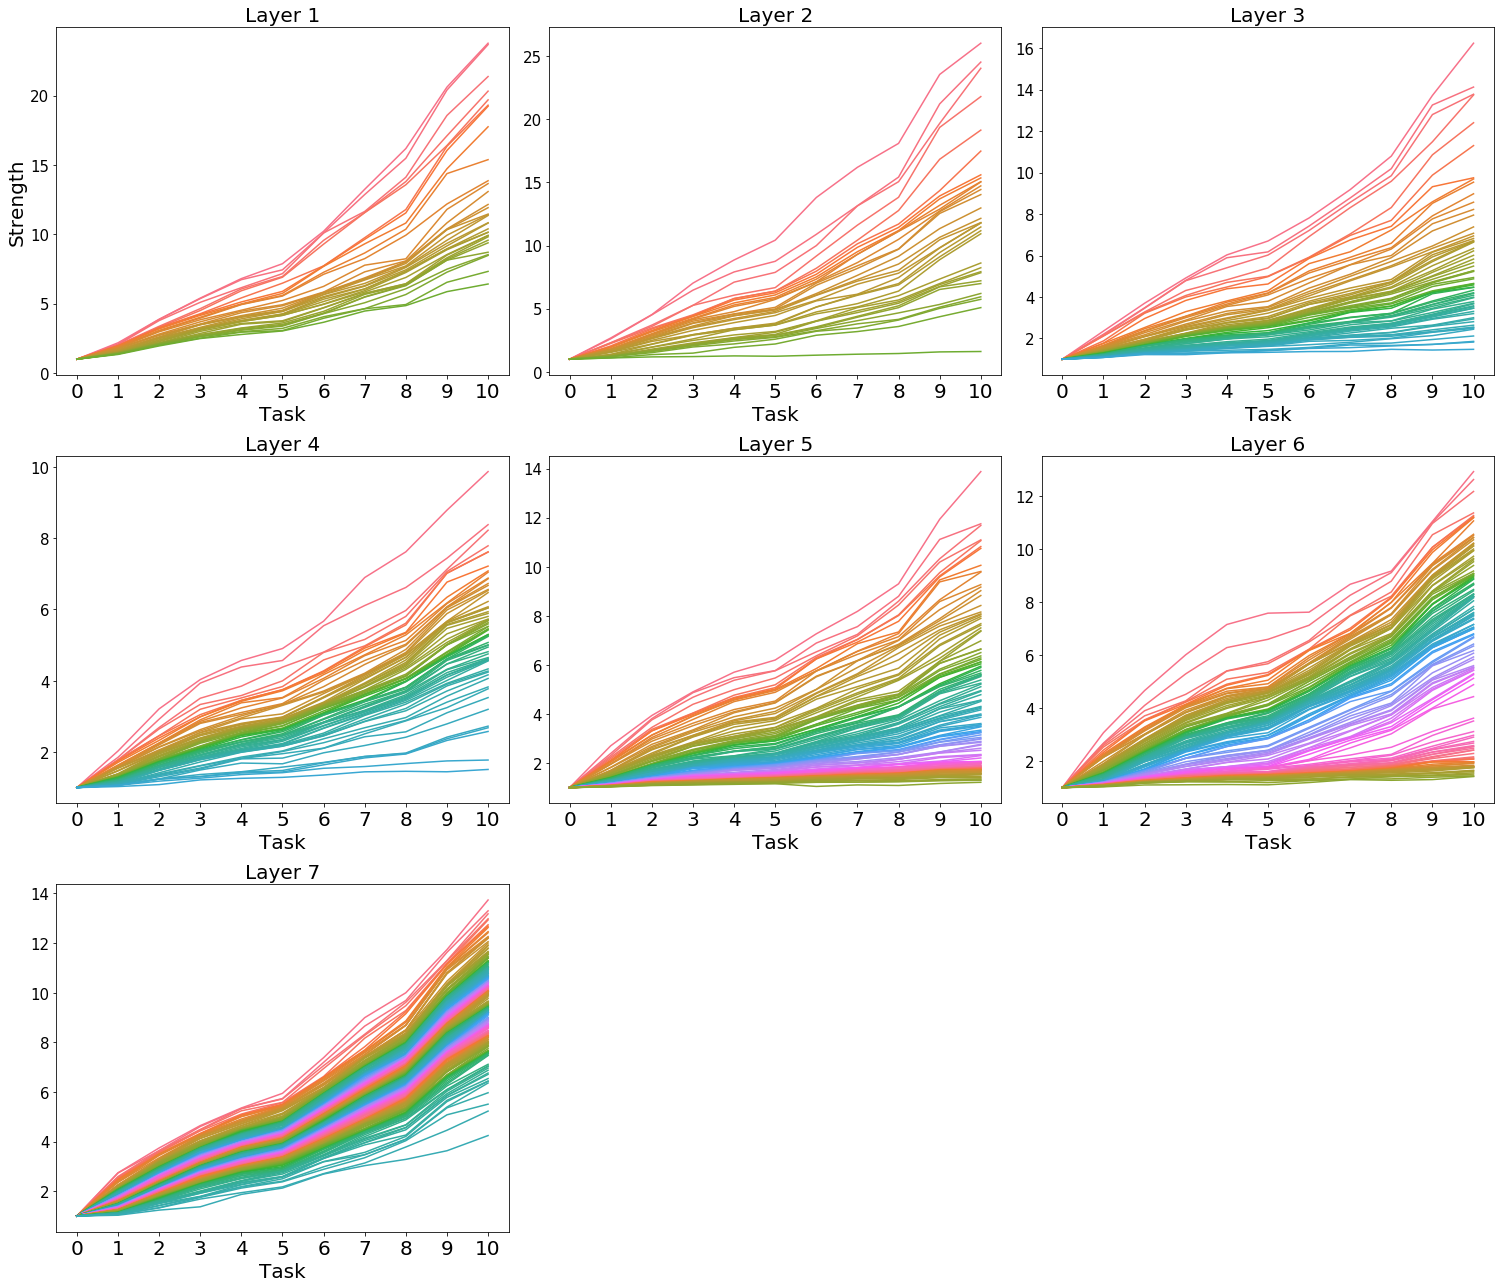

In [6]:
name = '../models/trained_model/REBUTTAL_split_cifar100_baye_0_beta_0.0001000_std_0.0350000_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
weight_channel_wise_histogram(name, std_init = 0.035)

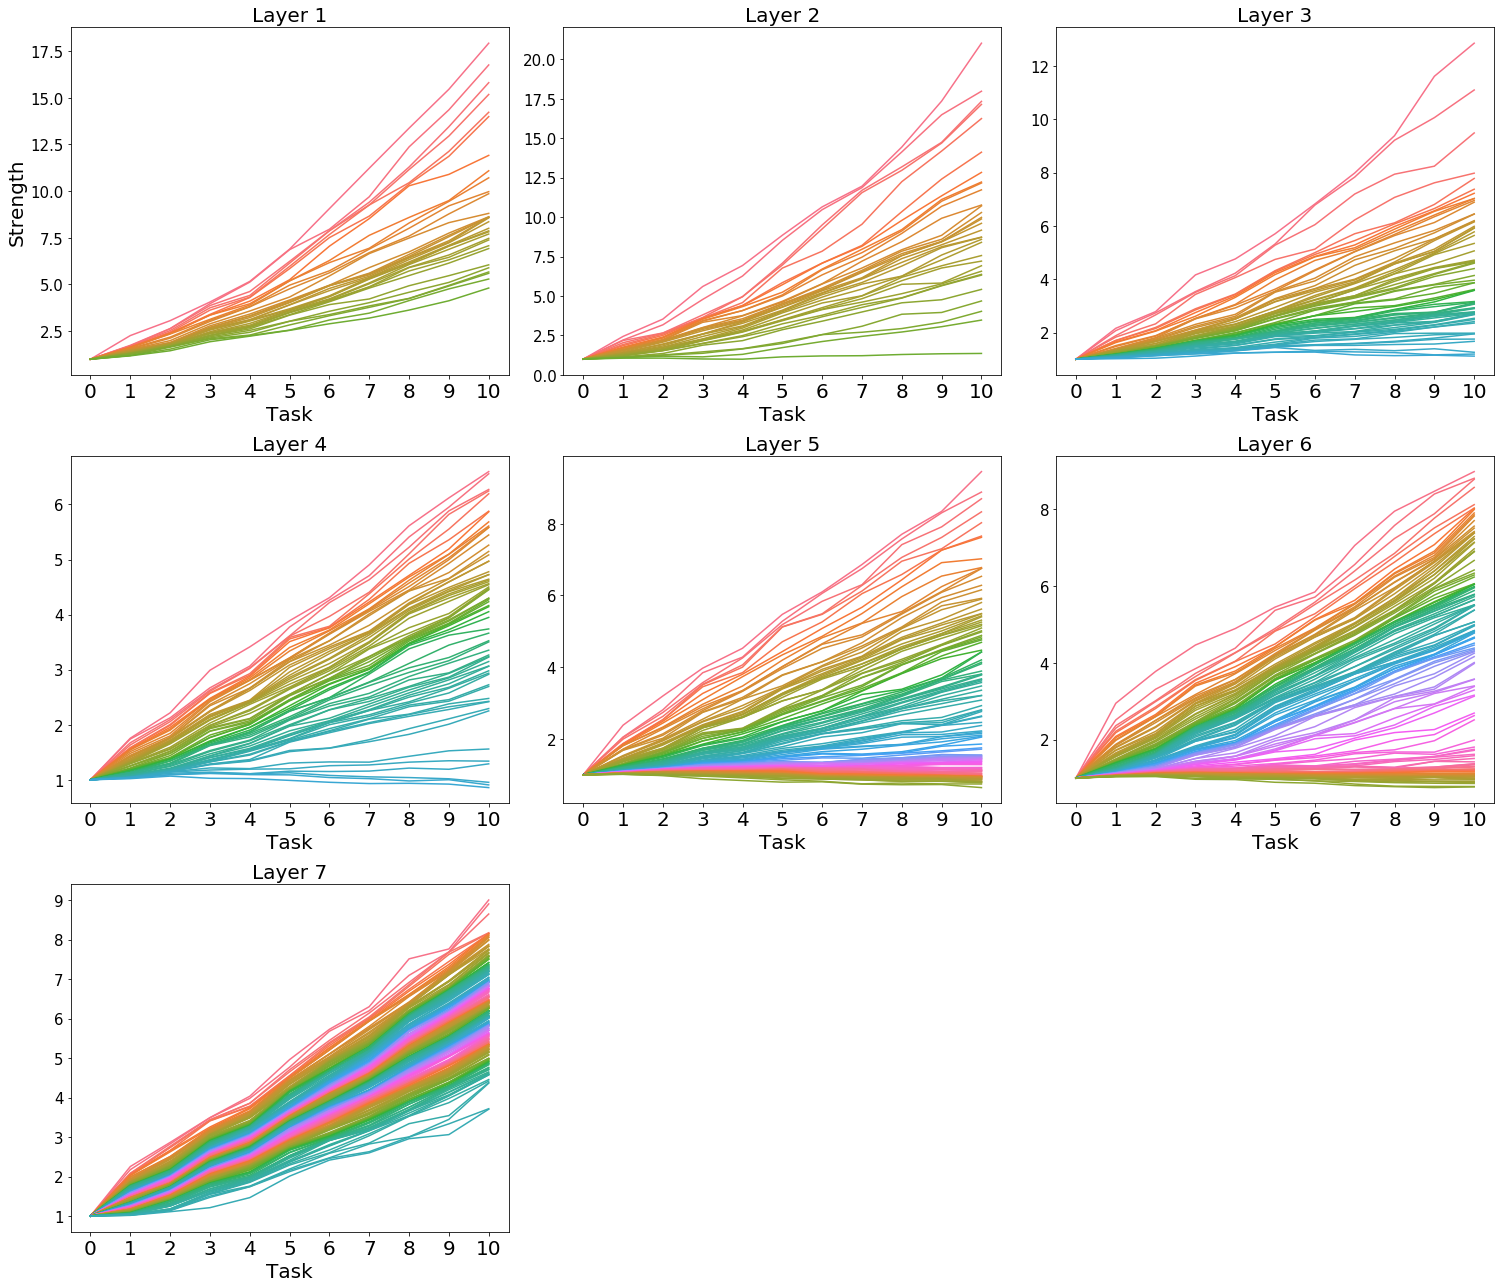

In [7]:
name = '../models/trained_model/REBUTTAL_split_cifar100_baye_0_beta_0.0100000_std_0.0350000_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
weight_channel_wise_histogram(name, std_init = 0.035)